## Digit Recognition

CNN for Kaggle competition.  Data avialable at: https://www.kaggle.com/competitions/digit-recognizer/overview

### Import Libraries and Data

In [1]:
#loading libraries
import pandas as pd
import datetime
import numpy as np
import tensorflow
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
#loading training data
df = pd.read_csv("train.csv")
print(df.shape)

(42000, 785)


In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#loading test data
df_test = pd.read_csv("test.csv")
df_test.shape

(28000, 784)

In [5]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Standardizing the Independent Variables

We are going to do a PCA.  PCA is effected by scale so we standardize the data here and will use the standarized data throughout the entirity of the analysis

In [6]:
#merge datasets together and then scale
df_temp1 = df.drop(columns=['label'])
df_temp1['source'] = 'train'
df_temp2 = df_test
df_temp2['source'] = 'test'
join_list = [df_temp1,df_temp2]
df_comb = pd.concat(join_list)
df_comb.shape
source = df_comb['source'].to_list()
df_comb2 = df_comb.drop(columns=['source'])
del df_temp1, df_temp2, df_comb

In [7]:
#apply scaling to joined test and train data
col_list = df_comb2.columns
scaler = StandardScaler()
model2=scaler.fit(df_comb2)
df_standard=model2.transform(df_comb2)
df_standard = pd.DataFrame(df_standard,columns=col_list)
print(df_standard.shape)
df_standard.describe()

(70000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,7.000000e+04,7.000000e+04,7.000000e+04,7.000000e+04,7.000000e+04,7.000000e+04,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.823623e-15,-1.137216e-15,2.825315e-15,-3.964385e-16,1.831964e-15,1.212366e-15,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.295091e-02,-2.338733e-02,-1.675050e-02,-1.063784e-02,-8.339086e-03,-5.342334e-03,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.295091e-02,-2.338733e-02,-1.675050e-02,-1.063784e-02,-8.339086e-03,-5.342334e-03,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.295091e-02,-2.338733e-02,-1.675050e-02,-1.063784e-02,-8.339086e-03,-5.342334e-03,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.295091e-02,-2.338733e-02,-1.675050e-02,-1.063784e-02,-8.339086e-03,-5.342334e-03,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.236282e+01,5.965323e+01,9.086908e+01,1.619808e+02,1.634635e+02,1.932091e+02,0.0,0.0,0.0,0.0


In [8]:
df_standard['source'] = source
df_standard.shape

(70000, 785)

### Accuracy Function

In [9]:
#bulding a function to evaluate model accuracy
def score(predict,actual):
    return sum(predict == actual) / len(actual)

### Neural Network

In [10]:
#need to create the hotkey encoding
y = to_categorical(df['label'], num_classes = 10)

In [11]:
#reshaping the data
X = df_standard[df_standard['source'] == 'train']
X = X.drop(columns=['source']).values
X = X.reshape(-1,28,28,1)

In [12]:
#going to recreate the cross validation
#because of the new hotkey encoding and reshaping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(33600, 28, 28, 1)
(8400, 28, 28, 1)
(33600, 10)
(8400, 10)


In [13]:
#also going to create the train_test split for y values at are not hotkey encoded.  
#this will making testing accuracy a little easier later on
#using the same random_state as above so we get the same splits
y_actual = (df['label'])
temp1, temp2, y_train_digit, y_test_digit = train_test_split(X, y_actual, test_size=0.2, random_state=0)
print(y_train_digit.shape)
print(y_test_digit.shape)

(33600,)
(8400,)


In [14]:
#building and compiling model 1
#one convulution layer and two other hidden layers
#10 nodes in each dense layer

model1 = Sequential()

model1.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', input_shape = (28,28,1)))
model1.add(Flatten())
model1.add(Dense(10, activation = "relu"))
model1.add(Dense(10, activation = "relu"))
model1.add(Dense(10, activation = "softmax"))

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 10)                184330    
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 185,382
Trainable params: 185,382
Non-trainable params: 0
_________________________________________________________________


In [15]:
#building and compiling model 2
#one convulution layer and two other hidden layers
#100 nodes in each dense layer

model2 = Sequential()

model2.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', input_shape = (28,28,1)))
model2.add(Flatten())
model2.add(Dense(100, activation = "relu"))
model2.add(Dense(100, activation = "relu"))
model2.add(Dense(10, activation = "softmax"))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               1843300   
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 1,855,242
Trainable params: 1,855,242
Non-trainable params: 0
_________________________________________________________________


In [16]:
#building and compiling model 3
#one convulution layer and four other hidden layers
#10 nodes in each dense layer

model3 = Sequential()

model3.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', input_shape = (28,28,1)))
model3.add(Flatten())
model3.add(Dense(10, activation = "relu"))
model3.add(Dense(10, activation = "relu"))
model3.add(Dense(10, activation = "relu"))
model3.add(Dense(10, activation = "relu"))
model3.add(Dense(10, activation = "softmax"))

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_6 (Dense)             (None, 10)                184330    
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 10)                110       
                                                                 
 dense_9 (Dense)             (None, 10)                110       
                                                                 
 dense_10 (Dense)            (None, 10)               

In [17]:
#building and compiling model 4
#one convulution layer and four other hidden layers
#100 nodes in each dense layer

model4 = Sequential()

model4.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', input_shape = (28,28,1)))
model4.add(Flatten())
model4.add(Dense(100, activation = "relu"))
model4.add(Dense(100, activation = "relu"))
model4.add(Dense(100, activation = "relu"))
model4.add(Dense(100, activation = "relu"))
model4.add(Dense(10, activation = "softmax"))

model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 flatten_3 (Flatten)         (None, 18432)             0         
                                                                 
 dense_11 (Dense)            (None, 100)               1843300   
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                                 
 dense_14 (Dense)            (None, 100)               10100     
                                                                 
 dense_15 (Dense)            (None, 10)               

In [18]:
#fit each model

start1=datetime.datetime.now()
model1.fit(X_train, y_train, epochs=2, batch_size=100)
end1=datetime.datetime.now()


start2=datetime.datetime.now()
model2.fit(X_train, y_train, epochs=2, batch_size=100)
end2=datetime.datetime.now()

start3=datetime.datetime.now()
model3.fit(X_train, y_train, epochs=2, batch_size=100)
end3=datetime.datetime.now()

start4=datetime.datetime.now()
model4.fit(X_train, y_train, epochs=2, batch_size=100)
end4=datetime.datetime.now()


Epoch 1/2
336/336 [==============================] - 6s 15ms/step - loss: 0.5611 - accuracy: 0.8196
Epoch 2/2
336/336 [==============================] - 5s 14ms/step - loss: 0.1579 - accuracy: 0.9543
Epoch 1/2
336/336 [==============================] - 7s 20ms/step - loss: 0.2221 - accuracy: 0.9320
Epoch 2/2
336/336 [==============================] - 7s 20ms/step - loss: 0.0743 - accuracy: 0.9774
Epoch 1/2
336/336 [==============================] - 7s 19ms/step - loss: 1.2414 - accuracy: 0.5588
Epoch 2/2
336/336 [==============================] - 6s 17ms/step - loss: 0.3670 - accuracy: 0.9008
Epoch 1/2
336/336 [==============================] - 8s 21ms/step - loss: 0.2417 - accuracy: 0.9262
Epoch 2/2
336/336 [==============================] - 7s 21ms/step - loss: 0.0848 - accuracy: 0.9734


In [19]:
#make a prediction on holdout data and translate to label

prediction1 = model1.predict(X_test)
prediction2 = model2.predict(X_test)
prediction3 = model3.predict(X_test)
prediction4 = model4.predict(X_test)

prediction1 = np.argmax(prediction1,axis = 1)
prediction2 = np.argmax(prediction2,axis = 1)
prediction3 = np.argmax(prediction3,axis = 1)
prediction4 = np.argmax(prediction4,axis = 1)

#make a prediction on training data and translate to label

prediction5 = model1.predict(X_train)
prediction6 = model2.predict(X_train)
prediction7 = model3.predict(X_train)
prediction8 = model4.predict(X_train)

prediction5 = np.argmax(prediction5,axis = 1)
prediction6 = np.argmax(prediction6,axis = 1)
prediction7 = np.argmax(prediction7,axis = 1)
prediction8 = np.argmax(prediction8,axis = 1)

1050/1050 [==============================] - 7s 7ms/step


In [20]:
#just checking that we are getting reasonable outputs
print(np.unique(prediction1))
print(np.unique(prediction2))
print(np.unique(prediction3))
print(np.unique(prediction4))
print(np.unique(prediction5))
print(np.unique(prediction6))
print(np.unique(prediction7))
print(np.unique(prediction8))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [21]:
#evaluate accuracy
score1 = score(prediction1,y_test_digit)
score2 = score(prediction2,y_test_digit)
score3 = score(prediction3,y_test_digit)
score4 =score(prediction4,y_test_digit)

score5 =score(prediction5,y_train_digit)
score6 =score(prediction6,y_train_digit)
score7 =score(prediction7,y_train_digit)
score8 =score(prediction8,y_train_digit)

In [22]:
#creating the experiment cross-table
d = {'Model':['Model1','Model2','Model3','Model4'],'Nodes':[2,2,4,4],'Layers':[10,100,10,100],'Time':[end1-start1,end2-start2,end3-start3,end4-start4],'Test Accuracy':[score1,score2,score3,score4],'Train Accuarcy':[score5,score6,score7,score8]}
cross_t = pd.DataFrame(d)
cross_t

,Model,Nodes,Layers,Time,Test Accuracy,Train Accuarcy
0,Model1,2,10,0 days 00:00:10.978455,0.957976,0.970595
1,Model2,2,100,0 days 00:00:13.993535,0.974167,0.989405
2,Model3,4,10,0 days 00:00:12.839884,0.922024,0.928810
3,Model4,4,100,0 days 00:00:14.901011,0.971786,0.985327


In [23]:
#building a kaggle submission for each model

df_submit = df_standard[df_standard['source'] == 'test']
df_submit = df_submit.drop(columns=['source']).values
df_submit = df_submit.reshape(-1,28,28,1)
print(df_submit.shape)

sub1 = model1.predict(df_submit)
sub2 = model2.predict(df_submit)
sub3 = model3.predict(df_submit)
sub4 = model4.predict(df_submit)

sub1 = np.argmax(sub1,axis = 1)
sub2 = np.argmax(sub2,axis = 1)
sub3 = np.argmax(sub3,axis = 1)
sub4 = np.argmax(sub4,axis = 1)


sub1 = pd.DataFrame(data=sub1,columns=['Label'])
sub2 = pd.DataFrame(data=sub2,columns=['Label'])
sub3 = pd.DataFrame(data=sub3,columns=['Label'])
sub4 = pd.DataFrame(data=sub4,columns=['Label'])

sub1['ImageId'] = sub1.index + 1
sub2['ImageId'] = sub2.index + 1
sub3['ImageId'] = sub3.index + 1
sub4['ImageId'] = sub4.index + 1

sub1 = sub1[['ImageId','Label']]
sub2 = sub2[['ImageId','Label']]
sub3 = sub3[['ImageId','Label']]
sub4 = sub4[['ImageId','Label']]

print(sub1.head())

print(sub1.shape)
print(sub2.shape)
print(sub3.shape)
print(sub4.shape)

sub1.to_csv('NN_1.csv',index=False)
sub2.to_csv('NN_2.csv',index=False)
sub3.to_csv('NN_3.csv',index=False)
sub4.to_csv('NN_4.csv',index=False)

(28000, 28, 28, 1)
875/875 [==============================] - 5s 6ms/step
   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3
(28000, 2)
(28000, 2)
(28000, 2)
(28000, 2)


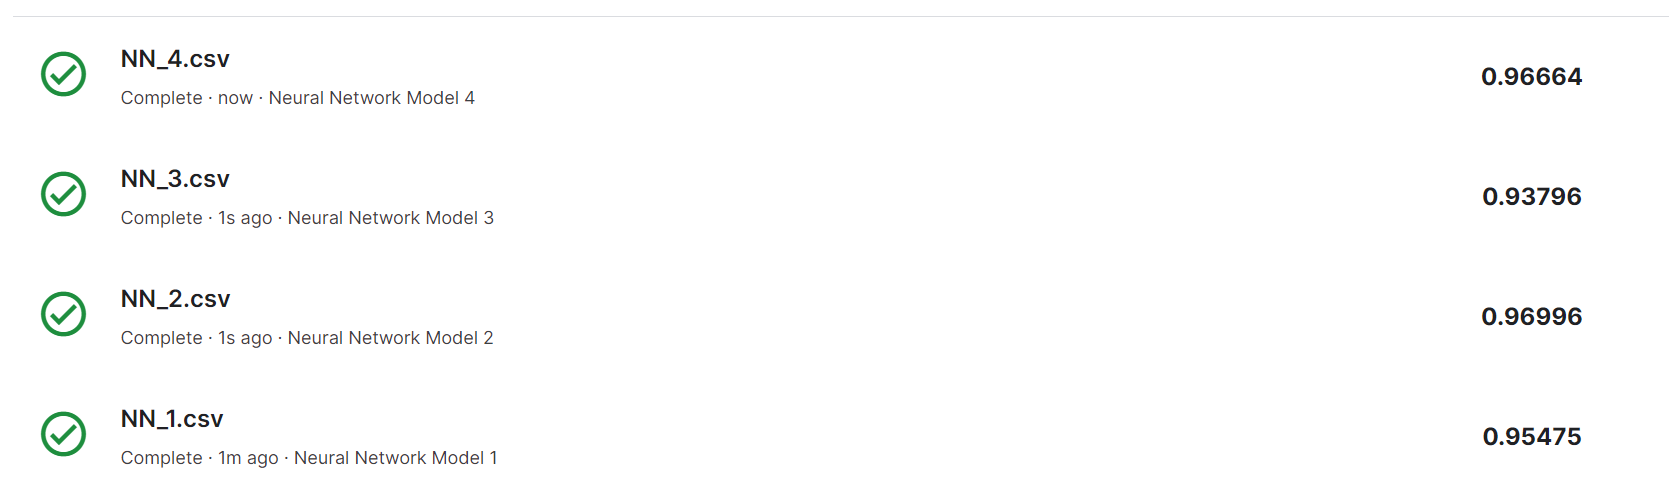

263/263 [==============================] - 2s 6ms/step


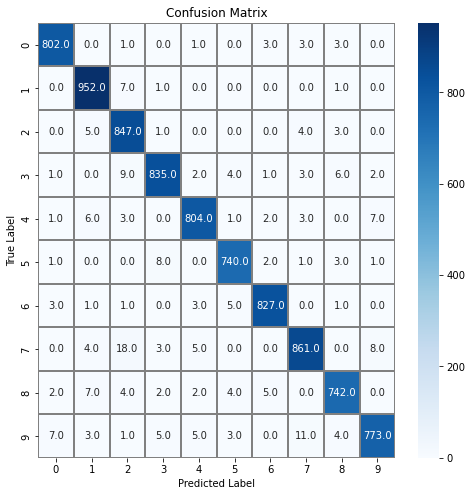

In [24]:
# confusion matrix
Y_pred = model2.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
confusion_mtx = confusion_matrix(y_test_digit, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

The model is working pretty well across most digits.  The largest problem appears to be "7"s which are being predicited to be "2"s.

The nueral network performs well.  Accuracy on the test data outperforms all other models.  We select this model as our final model